# Introduction

This Kaggle competition is about combining different predictions to generate a new one with superior performance, i.e., it is about ensembles. The exercise was interesting, however, there was nearly no data analysis or data engineering, it was very focused on performance, and extracting every bit of performance one can get from different methods. Nevertheless, it was still really fun to participate, and I learned quite a lot.

## Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import log_loss,make_scorer
from catboost import CatBoostClassifier

from sklearn.decomposition import PCA

In [2]:
submission = pd.read_csv('sample_submission.csv', index_col='id')
labels = pd.read_csv('train_labels.csv', index_col='id')
sub_ids = submission.index
gt_ids = labels.index 
subs = sorted(os.listdir('./Data'))

Saving all the submissions in a single dataframe. The submissions with very low standard deviations, which means that all predictions are about the same, will be dropped. If all predictions are of a single class, the submission will also be removed. If the predictions contain values below 0 or above 1, they will also be discarded, since there are only about 40 of these cases and they might be associated with wrong modelling. Finally, submissions too strongly correlated will also be dropped. The 0.97 number was chosen empirically, after trying with 0.96, 0.98 and 0.99. It does not change the final result, as long as it is not much smaller. 

In [3]:
# loop to add each submission to a single dataframe
std_thr=0.01  # If a column has a standard deviation lower than 0.01, don't add it
corr_thr=0.97 # If a column has a too large correlation with any of the other columns, don't add it to the dataframe

for i,sub in enumerate(subs):
    if (i+1) % 1000 == 0:
        print(i+1," steps performed.")
        
    df_temp = pd.read_csv('Data/'+sub, index_col='id')
    
    # Cut by standard deviation
    if np.std(df_temp)[0]<std_thr:
        continue

    # If it contains values above 1 or below zero, drop        
    if ( (np.min(df_temp)[0] < 0) | (np.max(df_temp)[0] > 1) ):
        continue    
        
    # If nearly all observations belong to the same class, drop
    if ( (df_temp > 0.5).sum()[0] > 39990 | (df_temp < 0.5).sum()[0] > 39990 ):
        continue
        
    # Compare the correlation of the new column with each column of df, if any of these values are too high, ignore the column
    name='pred_'+str(i)
    df_temp.columns=[name]
    if i == 0:
        df=df_temp
        continue
    else:
        a=df.corrwith(df_temp[name])
        if all(abs(a) < corr_thr):
            df=pd.concat([df,df_temp],axis=1)

1000  steps performed.
2000  steps performed.
3000  steps performed.
4000  steps performed.
5000  steps performed.


In [4]:
# Info on the dataframe
print(df.shape)
print(df.info())

(40000, 1457)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Columns: 1457 entries, pred_0 to pred_4999
dtypes: float64(1457)
memory usage: 444.9 MB
None


So it started with 5000 submissions, and removing bad or strongly correlated features reduced the total number to about 1500 submissions.

# Exploratory data Analysis

This was performed in a previous notebook. The main conclusions were that the submissions are unbalanced, while the target column is perfectly balanced. There are no missing values and a few cases where the predictions were out of bound, less than 0 or larger than 1.

Due to these negative and larger than 1 values, all values will be forced to be inside the 0-1 range.

In [5]:
# Well behaved values
for col in df.columns:        
    a=df[col].apply(lambda x:max(x,0.0001))
    a=a.apply(lambda x:min(x,0.9999))
    df[col]=a
print("Min, Max: ",np.min(np.min(df)),np.max(np.max(df)))

Min, Max:  0.0001 0.9999


So now one has about 1500 submissions, each with values between 0.0001 and 0.9999. Let's optimize each submission by searching for negative shifts that might improve their score. Defining a function for this:

In [98]:
def shifting3(df):
    # array containing the original and new scores: to be returned
    scores=[]
    
    # A new dataframe will be returned
    new_df=df.copy()

    # Displacement delta: the lower the value, the more accurate, and the slower the calculation
    disp=0.002

    # Main loop: to every column, optimize the score of the column 
    counter=0
    for col in new_df.columns:
        # Original score
        X_previous=new_df[col].copy()
        X_previous=X_previous[:20000]
        original_score=log_loss(labels,X_previous)        
        
        best_i_pos=0
        best_i_neg=0
        best_score_pos = original_score
        best_score_neg = original_score

        # Finding out the optimizal positive and negative displacement 
        for i in range(1,200):
            X_new=X_previous.apply(lambda x: (x+i*disp) if x >= 0.5 else x)
            X_new=X_new.apply(lambda x:min(x,0.9999))    # To be sure that no value is lower than 0.0001
            new_score=log_loss(labels,X_new)
            if new_score < best_score_pos:
                best_i_pos=i
                best_score_pos=new_score
            else:
                break
        for i in range(1,200):
            X_new=X_previous.apply(lambda x: (x+i*disp) if x < 0.5 else x)    
            X_new=X_new.apply(lambda x:max(x,0.0001))    # To be sure that no value is lower than 0.0001
            new_score=log_loss(labels,X_new)
            if new_score < best_score_neg:
                best_i_neg=i
                best_score_neg=new_score
            else:
                break

        # Applying the optimal shifts
        new_df[col] = new_df[col].apply(lambda x: (x+best_i_pos*disp) if x > 0.5 else (x+best_i_neg*disp))        
        new_df[col]=new_df[col].apply(lambda x:min(x,0.9999))
        new_df[col]=new_df[col].apply(lambda x:max(x,0.0001))
        new_score=log_loss(labels, new_df[col][:20000])
        
        scores.append([original_score,new_score])
        counter+=1
        if counter % 100 == 0:
            print(counter,"steps performed.")

    return scores,new_df

In [99]:
scores3,df3=shifting3(df)

100 steps performed.
200 steps performed.
300 steps performed.
400 steps performed.
500 steps performed.
600 steps performed.
700 steps performed.
800 steps performed.
900 steps performed.
1000 steps performed.
1100 steps performed.
1200 steps performed.
1300 steps performed.
1400 steps performed.


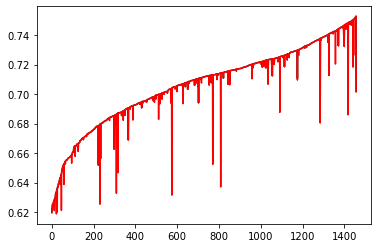

In [100]:
scores3=pd.DataFrame(scores3)
plt.plot(list(range(len(scores3))),scores3.iloc[:,0],color='black');
plt.plot(list(range(len(scores3))),scores3.iloc[:,1],color='red');

Repeating the same procedure, but taking into account the negative displacements.

In [101]:
def shifting4(df):
    # array containing the original and new scores: to be returned
    scores=[]
    
    # A new dataframe will be returned
    new_df=df.copy()

    # Displacement delta: the lower the value, the more accurate, and the slower the calculation
    disp=0.002

    # Main loop: to every column, optimize the score of the column 
    counter=0
    for col in new_df.columns:
        # Original score
        X_previous=new_df[col].copy()
        X_previous=X_previous[:20000]
        original_score=log_loss(labels,X_previous)        
        
        best_i_pos=0
        best_i_neg=0
        best_score_pos = original_score
        best_score_neg = original_score

        # Finding out the optimizal positive and negative displacement 
        for i in range(1,200):
            X_new=X_previous.apply(lambda x: (x-i*disp) if x >= 0.5 else x)
            X_new=X_new.apply(lambda x:min(x,0.9999))    # To be sure that no value is higher than 0.9999
            new_score=log_loss(labels,X_new)
            if new_score < best_score_pos:
                best_i_pos=i
                best_score_pos=new_score
            else:
                break
        for i in range(1,200):
            X_new=X_previous.apply(lambda x: (x-i*disp) if x < 0.5 else x)    
            X_new=X_new.apply(lambda x:max(x,0.0001))    # To be sure that no value is lower than 0.0001
            new_score=log_loss(labels,X_new)
            if new_score < best_score_neg:
                best_i_neg=i
                best_score_neg=new_score
            else:
                break

        # Applying the optimal shifts
        new_df[col] = new_df[col].apply(lambda x: (x-best_i_pos*disp) if x > 0.5 else (x-best_i_neg*disp))        
        new_df[col]=new_df[col].apply(lambda x:max(x,0.0001))
        new_df[col]=new_df[col].apply(lambda x:min(x,0.9999))
        new_score=log_loss(labels, new_df[col][:20000])
        
        scores.append([original_score,new_score])
        counter+=1
        if counter % 100 == 0:
            print(counter,"steps performed.")

    return scores,new_df

100 steps performed.
200 steps performed.
300 steps performed.
400 steps performed.
500 steps performed.
600 steps performed.
700 steps performed.
800 steps performed.
900 steps performed.
1000 steps performed.
1100 steps performed.
1200 steps performed.
1300 steps performed.
1400 steps performed.


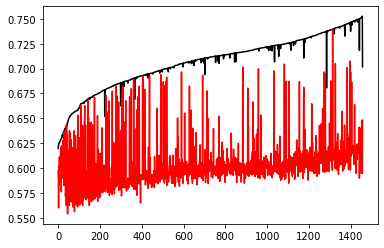

In [102]:
scores4,df4=shifting4(df3)

scores4=pd.DataFrame(scores4)
plt.plot(list(range(len(scores4))),scores3.iloc[:,0],color='black');
plt.plot(list(range(len(scores4))),scores4.iloc[:,1],color='red');

Before modelling, let's check how can one change the original dataset as to improve the final predictions.

# Shifting and scaling the submissions

In the previous EDA section, it was noted that the target column is perfectly balanced, with 50/50% of 0/1 predictions. The 5000 submissions are, however, mostly unbalanced. Many things can be done in order to "remedy" this. Directly modelling the dataframe using a logistic regression or other methods is one way to do it. One can also shift/scale the submissions, creating a more balanced dataset. The main objective in the end is to get a better performance in the validation set.

The main idea of this work is: first, transform the submissions back to the "real" space, between -inf and inf, using the logit function. Then shift the median to the origin, so that half of the predictions are in the positive axis, and the other half in the negative. Then we inverse it back to the probability space. In this process, the original shape and deviation of the curve is lost. This could negatively affect the performance. Since the original standard deviation of the probabilities can be restored, a _scale_ parameter will be used, with the following properties:
1. If it is 1, then the standard deviation is completely restored;
2. If it is smaller than 1, then it will be partially restored. Do note that if it is too close to zero, then most of the predictions will be close to the media, 0.5, centered around it, meaning that all submissions will be quite similar. 
3. It it is negative, then the original standard deviation will be completely ignored, and the transformation will only shift to the median.

The _scale_ parameter will be adjusted to give a maximum score in the validation set.

Defining the functions:

In [65]:
# Useful functions
def expit(s):
    a=np.exp(-s)
    return 1/(1+a)
def logit(s):
    p=np.log(s)
    return p/(1-p)

# Shifting - restoring the original deviation up to a 'scale' value
def shift_norm_rest(d,scale):    
    out=d.copy()
    for col in out.columns:        
        delta_prev=np.max(out[col])-np.min(out[col]) # Store the original deviation

        # Shifting
        l=logit(out[col])
        l=l-np.median(l)
        shifted=expit(l)
        
        delta_aft=np.max(shifted)-np.min(shifted) # Evaluate the new deviation
        
        if scale > 0:
            # Restoring the original deviation up to a scale factor
            shifted=(shifted-0.5)*(delta_prev/delta_aft)*scale + 0.5 
        
        # Normalizing
        shifted=shifted.apply(lambda x:max(x,0.0001))
        shifted=shifted.apply(lambda x:min(x,0.9999))
        
        out[col]=shifted

    return out

Checking the effects of shifting/scaling the original submissions for 50 randomly chosen features (the larger the number of features selected, the slower the kde plot, so it is not advised to plot all data).

In [66]:
# Arrays to store the data
unmodified=[]
modified_scale0=[]
modified_scale1=[]
modified_scale2=[]

# Choose 50 random columns
random_set = set()
for i in range(0,50):
    random_set.add(random.randint(0,df4.shape[1]-1))
analysis=df4.iloc[:,list(random_set)].copy()

# Store the unmodified data
for col in analysis.columns:
    for value in analysis[col].values:
        unmodified.append(value.astype(float))

# Store the shifted data without any scaling
a0=shift_norm_rest(analysis,-1)
for col in a0.columns:
    for value in a0[col]:
        modified_scale0.append(value)
        
# Store the shifted data with scale 1
a1=shift_norm_rest(analysis,1)
for col in a1.columns:
    for value in a1[col]:
        modified_scale1.append(value)

# Store the shifted data with scale 0.5    
a2=shift_norm_rest(analysis,0.5)
for col in a2.columns:
    for value in a2[col]:
        modified_scale2.append(value)

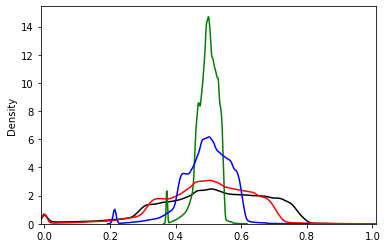

In [67]:
sns.kdeplot(unmodified,color='black');
sns.kdeplot(modified_scale0,color='green');
sns.kdeplot(modified_scale1,color='red');
sns.kdeplot(modified_scale2,color='blue');
plt.xlim(-0.01,1.01);

The black curve illustrated how the unmodified predictions are biased toward the _1_ class. Shifting without restoring (green curve) gives a much more balanced output, at the cost of significantly changing the original submission. Shifting and restoring the original standard deviation gives a broader range of predictions, with a range that can be adjusted with the value of _scale_. Reducing it from 1 to zero makes the peak sharper, putting less weight in the predictions that are close to 0 or 1, which can be good since a wrong prediction (0 instead of 1) is strongly penalized, while a less wrong one (0.4 instead of 1) is not that terrible.

Now let's model the unmodified and modified datasets.

# Modelling

Setting the train/val/test datasets.

In [106]:
X_test=df4[20000:]
X=df4[:20000]
y=np.ravel(labels)
print(X.shape,X_test.shape)

(20000, 1457) (20000, 1457)


## Using the original submissions

Since there are many features, too many for the number of observations at least, one could consider a dimensionality reduction.

In [69]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
#X_test_pca = pca.transform(X_test)
explained_variance = pd.Series(pca.explained_variance_ratio_)

count    1.457000e+03
mean     6.863418e-04
std      2.179164e-02
min      1.597833e-07
25%      1.557436e-05
50%      2.963527e-05
75%      6.084046e-05
max      8.312907e-01
dtype: float64


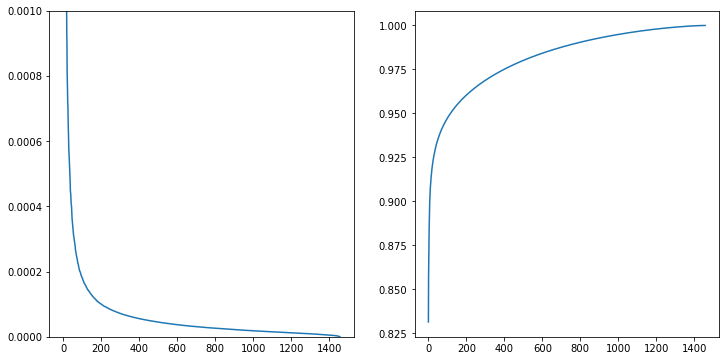

In [70]:
print(explained_variance.describe())
f,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
ax[0].plot(explained_variance);
ax[0].set_ylim(0,0.001);
ax[1].plot(np.cumsum(explained_variance));

So 83% of the variance is explained with just a single component, 90% with 7 and 99% with about 1000. Let's check the performance of 7 components, a reasonable number of features given the 20000 points dataset:

In [71]:
com7_train=X_train_pca[:,:7]
com7_val=X_val_pca[:,:7]

model = LogisticRegression(max_iter=10000);
model.fit(com7_train,y_train) 

pred_train=model.predict_proba(com7_train)[:,1]
pred_val=model.predict_proba(com7_val)[:,1]
print("7 components: ",np.round(log_loss(y_train,pred_train),4),np.round(log_loss(y_val,pred_val),4))

7 components:  0.5406 0.536


Not bad, and there is no overfit. As we add more features, one can expect that overfitting will be an issue.

Let's check how good are the predictions with increasingly large numbers of principal components. For this, we will use cross validation:

In [104]:
LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
cv = KFold(n_splits=5, random_state=55, shuffle=True)

In [73]:
pca_list= [10,25,50,75,100,150,200,300,400,500,1000]
res_train=[]

for number_components in pca_list:
    xtrain = X_train_pca[:,:number_components]
    temp=[]
    for C in [1,0.5,0.1,0.05,0.01]: # The lower the C value, the stronger the regularization
        log_reg = LogisticRegression(C=C,max_iter=10000);
        sc=cross_val_score(log_reg,xtrain,y_train,scoring=LogLoss,cv=cv,n_jobs=-1)
        temp.append(np.round(np.mean(-1.0*sc),4))
    res_train.append(temp)

In [74]:
res_train=pd.DataFrame(res_train)

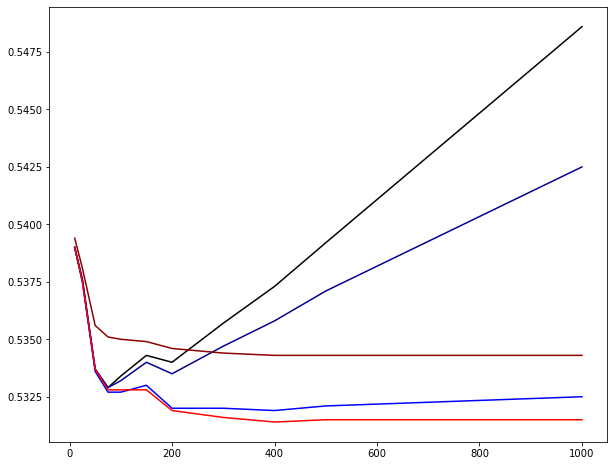

In [75]:
c=['black','darkblue','blue','red','darkred']
plt.figure(figsize=(10,8))
for i in range(5):
    plt.plot(pca_list,res_train.iloc[:,i],color=c[i]);

For the curve with low regularization (black curve), the score drops significantly at the beginning and as the number of components increases, the model starts overfitting, and the score gets worse. A clear minimum is found around 75 components. When regularization is stronger, one can postpone overfitting and get an extra boost in the score by using many more features. Too much overfitting does not help either, so there is a middle ground here.

So there are 2 routes one can follow here. Maximize the score using a few components, or using all features and strongly regularize. Let's see the final validation score on each case.

### Using a few features

Let's first optimize the number of ideal features.

In [76]:
chosen=[50,60,70,80,90,100,110,120,130]
for number_components in chosen:
    xtrain = X_train_pca[:,:number_components]
    xval = X_val_pca[:,:number_components]
    log_reg = LogisticRegression(C=1,max_iter=10000);
    sc=cross_val_score(log_reg,xtrain,y_train,scoring=LogLoss,cv=cv,n_jobs=-1)
    print(number_components,np.round(np.mean(sc),4))

50 -0.5337
60 -0.5335
70 -0.5327
80 -0.5332
90 -0.5332
100 -0.5334
110 -0.5337
120 -0.534
130 -0.534


So 80 components seem to be ideal. Now let's optimize and calculate the validation score:

In [77]:
number_components=80

param_grid = { 'C' : [1,0.5,0.1,0.05,0.01]} 

xtrain = X_train_pca[:,:number_components]
xval = X_val_pca[:,:number_components]

log_reg = LogisticRegression(max_iter=10000);
model = GridSearchCV(log_reg,param_grid,n_jobs=-1,cv=cv,scoring=LogLoss)
model.fit(xtrain,y_train) 

pred_train=model.predict_proba(xtrain)[:,1]
pred_val=model.predict_proba(xval)[:,1]
print(pd.DataFrame(model.cv_results_)[['params','mean_test_score','std_test_score']])    
print(np.round(log_loss(y_train,pred_train),4),np.round(log_loss(y_val,pred_val),4))

        params  mean_test_score  std_test_score
0     {'C': 1}        -0.533167        0.010165
1   {'C': 0.5}        -0.533082        0.010069
2   {'C': 0.1}        -0.532802        0.009495
3  {'C': 0.05}        -0.532902        0.009056
4  {'C': 0.01}        -0.535140        0.007968
0.529 0.5288


A final validation score of 0.5305. Using 300 features, the second minimum found in the red curve:

In [78]:
number_components=400

param_grid = { 'C' : [0.05]} 

xtrain = X_train_pca[:,:number_components]
xval = X_val_pca[:,:number_components]

log_reg = LogisticRegression(max_iter=10000);
model = GridSearchCV(log_reg,param_grid,n_jobs=-1,cv=cv,scoring=LogLoss)
model.fit(xtrain,y_train) 

pred_train=model.predict_proba(xtrain)[:,1]
pred_val=model.predict_proba(xval)[:,1]
print(pd.DataFrame(model.cv_results_)[['params','mean_test_score','std_test_score']])    
print(np.round(log_loss(y_train,pred_train),4),np.round(log_loss(y_val,pred_val),4))

        params  mean_test_score  std_test_score
0  {'C': 0.05}        -0.531437        0.009337
0.5212 0.5268


Even better. Everything seems consistent so far. Let's check using all the features.

### Using all features

Forgetting about PCA, let's use the complete matrix. A grid-search is performed to look for the amount of regularization that optimizes the score.

In [79]:
param_grid = { 'C' : [0.08,0.07,0.06,0.05,0.04,0.03]}

log_reg = LogisticRegression(max_iter=10000);
model = GridSearchCV(log_reg,param_grid,n_jobs=-1,cv=cv,scoring=LogLoss)
model.fit(X_train,y_train)    
print(pd.DataFrame(model.cv_results_)[['params','mean_test_score','std_test_score']])    

        params  mean_test_score  std_test_score
0  {'C': 0.08}        -0.531881        0.010005
1  {'C': 0.07}        -0.531657        0.009859
2  {'C': 0.06}        -0.531491        0.009697
3  {'C': 0.05}        -0.531403        0.009496
4  {'C': 0.04}        -0.531451        0.009261
5  {'C': 0.03}        -0.531718        0.008975


A C value of 0.05 was found to be optimal. With this value, the score is:

In [80]:
pred_train=model.predict_proba(X_train)[:,1]
pred_val=model.predict_proba(X_val)[:,1]
print(np.round(log_loss(y_train,pred_train),4),np.round(log_loss(y_val,pred_val),4))

0.5139 0.5267


0.529, a bit less then before. But the difference is not that large. Both routes will be considered again next.

More can be done here but it seems more productive to spend more time engineering each submission instead.

## Shifting and scaling the submissions

Let's repeat the previous analysis applying the already presented and discussed changes in the submissions.

### Shifting and restoring - scale 1

In [81]:
scale=1

X2_train=shift_norm_rest(X_train,scale)
X2_val=shift_norm_rest(X_val,scale)

pca = PCA()
X2_train_pca = pca.fit_transform(X2_train)
X2_val_pca = pca.transform(X2_val)
explained_variance = pd.Series(pca.explained_variance_ratio_)
print(explained_variance.describe())

count    1.457000e+03
mean     6.863418e-04
std      2.162152e-02
min      2.265859e-07
25%      1.496405e-05
50%      2.843816e-05
75%      5.951575e-05
max      8.247158e-01
dtype: float64


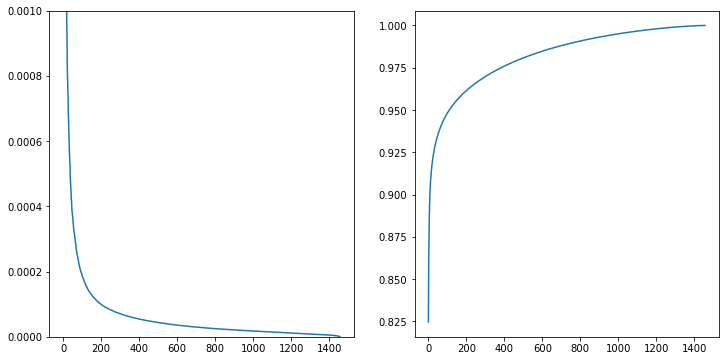

In [82]:
f,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
ax[0].plot(explained_variance);
ax[0].set_ylim(0,0.001);
ax[1].plot(np.cumsum(explained_variance));

A very similar plot as before, starting with 84% with a single component and 99% at around 1000 components.

In [83]:
res_train=[]

for number_components in pca_list:
    xtrain = X2_train_pca[:,:number_components]
    temp=[]
    for C in [10,1,0.5,0.1,0.05,0.01]: # The lower the C value, the stronger the regularization
        log_reg = LogisticRegression(C=C,max_iter=10000);
        sc=cross_val_score(log_reg,xtrain,y_train,scoring=LogLoss,cv=cv,n_jobs=-1)
        temp.append(np.round(np.mean(-1.0*sc),4))
    res_train.append(temp)
    print(number_components," finished.")

10  finished.
25  finished.
50  finished.
75  finished.
100  finished.
150  finished.
200  finished.
300  finished.
400  finished.
500  finished.
1000  finished.


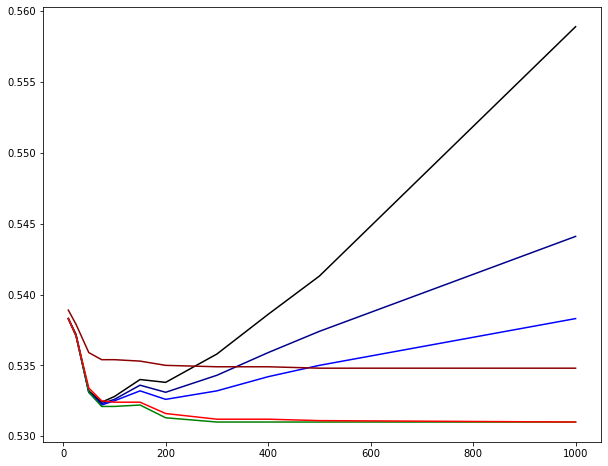

In [84]:
res_train=pd.DataFrame(res_train)

c=['black','darkblue','blue','green','red','darkred']
plt.figure(figsize=(10,8))
for i in range(6):
    plt.plot(pca_list,res_train.iloc[:,i],color=c[i]);

Now one needs a larger C value to suppress the regularization, 10 or even higher. A clear minimum is found again at around 75 components. Regularizing with C between 0.05 and 0.1 gives the best score, using 250 or 500 components. One could also use all components with C equal to 0.05. Let's check the validation score on each of these cases:

In [85]:
# Using a few features
number_components=80

param_grid = { 'C' : [0.07,0.05]} # Just check if regularizing less can improve a bit

xtrain = X2_train_pca[:,:number_components]
xval = X2_val_pca[:,:number_components]

log_reg = LogisticRegression(max_iter=10000);
model = GridSearchCV(log_reg,param_grid,n_jobs=-1,cv=cv,scoring=LogLoss)
model.fit(xtrain,y_train) 

pred_train=model.predict_proba(xtrain)[:,1]
pred_val=model.predict_proba(xval)[:,1]
print(np.round(log_loss(y_train,pred_train),4),np.round(log_loss(y_val,pred_val),4))

0.529 0.5276


In [86]:
# Using 200 features
number_components=200

param_grid = { 'C' : [0.07,0.05]} # Just check if regularizing less can improve a bit

xtrain = X2_train_pca[:,:number_components]
xval = X2_val_pca[:,:number_components]

log_reg = LogisticRegression(max_iter=10000);
model = GridSearchCV(log_reg,param_grid,n_jobs=-1,cv=cv,scoring=LogLoss)
model.fit(xtrain,y_train) 

pred_train=model.predict_proba(xtrain)[:,1]
pred_val=model.predict_proba(xval)[:,1]
print(np.round(log_loss(y_train,pred_train),4),np.round(log_loss(y_val,pred_val),4))

0.5248 0.5258


In [87]:
# Using 500 features
number_components=500

param_grid = { 'C' : [0.07,0.05]} # Just check if regularizing less can improve a bit

xtrain = X2_train_pca[:,:number_components]
xval = X2_val_pca[:,:number_components]

log_reg = LogisticRegression(max_iter=10000);
model = GridSearchCV(log_reg,param_grid,n_jobs=-1,cv=cv,scoring=LogLoss)
model.fit(xtrain,y_train) 

pred_train=model.predict_proba(xtrain)[:,1]
pred_val=model.predict_proba(xval)[:,1]
print(np.round(log_loss(y_train,pred_train),4),np.round(log_loss(y_val,pred_val),4))

0.5198 0.5262


In [88]:
# Using all features
param_grid = { 'C' : [0.07,0.05]}

log_reg = LogisticRegression(max_iter=10000);
model = GridSearchCV(log_reg,param_grid,n_jobs=-1,cv=cv,scoring=LogLoss)
model.fit(X2_train,y_train)    
print(pd.DataFrame(model.cv_results_)[['params','mean_test_score','std_test_score']])    

pred_train=model.predict_proba(X2_train)[:,1]
pred_val=model.predict_proba(X2_val)[:,1]
print(np.round(log_loss(y_train,pred_train),4),np.round(log_loss(y_val,pred_val),4))

        params  mean_test_score  std_test_score
0  {'C': 0.07}        -0.530771        0.009341
1  {'C': 0.05}        -0.530966        0.009015
0.514 0.5259


Better than before, by almost 0.02 points. Again, using all components is similar to using 500 components. The overall improvement was not a lot, though. Let's assume the same parameters will hold for other scale values and repeat this analysis, taken into account only the complete dataset. 

### Shifting and restoring - reducing the scale

Using all features, and reducing the scale:

In [89]:
# Using all features: changing the scale
param_grid = { 'C' : [0.07,0.05]}

for scale in np.arange(1,0.80,-0.05):
    X2_train=shift_norm_rest(X_train,scale)
    X2_val=shift_norm_rest(X_val,scale)   
    
    log_reg = LogisticRegression(max_iter=10000);
    model = GridSearchCV(log_reg,param_grid,n_jobs=-1,cv=cv,scoring=LogLoss)
    model.fit(X2_train,y_train) 

    pred_train=model.predict_proba(X2_train)[:,1]
    pred_val=model.predict_proba(X2_val)[:,1]
    print("Scale",np.round(scale,2),
          "Train/Val Scores:",np.round(log_loss(y_train,pred_train),4),np.round(log_loss(y_val,pred_val),4))

Scale 1.0 Train/Val Scores: 0.514 0.5259
Scale 0.95 Train/Val Scores: 0.515 0.5259
Scale 0.9 Train/Val Scores: 0.516 0.5259
Scale 0.85 Train/Val Scores: 0.5171 0.526


A small improvement.

### Catboost

For comparison, let's try a tree method, namely CatBoost, that has proven to give a very good performance in several different cases. A previous grid search was performed in another notebook, a very small one is made here just for illustration:

In [107]:
param_grid = { 'max_depth'         : [2,3,4],
               'learning_rate'     : [0.05,0.08] }
catboost = CatBoostClassifier(silent=True,od_type = "Iter",od_wait = 25,n_estimators=200);
model = GridSearchCV(catboost,param_grid,n_jobs=-1,cv=cv,scoring=LogLoss)
model.fit(X,y)    
pred=model.predict_proba(X)[:,1]

print(pd.DataFrame(model.cv_results_)[['params','mean_test_score','std_test_score']])    
print(np.round(log_loss(y,pred),4))

                                    params  mean_test_score  std_test_score
0  {'learning_rate': 0.05, 'max_depth': 2}        -0.527375        0.006334
1  {'learning_rate': 0.05, 'max_depth': 3}        -0.526915        0.005608
2  {'learning_rate': 0.05, 'max_depth': 4}        -0.526128        0.005704
3  {'learning_rate': 0.08, 'max_depth': 2}        -0.527014        0.006507
4  {'learning_rate': 0.08, 'max_depth': 3}        -0.527296        0.006180
5  {'learning_rate': 0.08, 'max_depth': 4}        -0.526504        0.006333
0.5098


In [108]:
scale=1
X_sc=shift_norm_rest(X,scale)
X_sc_test=shift_norm_rest(X_test,scale)

In [109]:
param_grid = { 'max_depth'         : [2,3,4],
               'learning_rate'     : [0.05,0.08] }
catboost = CatBoostClassifier(silent=True,od_type = "Iter",od_wait = 25,n_estimators=200);
model2 = GridSearchCV(catboost,param_grid,n_jobs=-1,cv=cv,scoring=LogLoss)
model2.fit(X_sc,y)    
pred=model2.predict_proba(X_sc)[:,1]

print(pd.DataFrame(model2.cv_results_)[['params','mean_test_score','std_test_score']])    
print(np.round(log_loss(y,pred),4))

                                    params  mean_test_score  std_test_score
0  {'learning_rate': 0.05, 'max_depth': 2}        -0.526721        0.005594
1  {'learning_rate': 0.05, 'max_depth': 3}        -0.526667        0.006263
2  {'learning_rate': 0.05, 'max_depth': 4}        -0.526192        0.005778
3  {'learning_rate': 0.08, 'max_depth': 2}        -0.527286        0.006010
4  {'learning_rate': 0.08, 'max_depth': 3}        -0.526730        0.006216
5  {'learning_rate': 0.08, 'max_depth': 4}        -0.527439        0.006519
0.5091


Better, and one can expect a bit of overfit. But nothing too dramatic.

From this point on, more can be done, using more, less or even dropping the validation set in order to use the complete dataset and try to improve the final score. However, for this particular competition I had much less time than I would have liked, and stopped the analysis here.

## Submission

In [111]:
pred=pd.DataFrame(model2.predict_proba(X_sc_test)[:,1],index=X_test.index,columns=['pred'])
pred.to_csv('Ultima4_scaled.csv')